In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid")

In [26]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
df_train = pd.read_csv("../data/dataset/train.csv")
df_test = pd.read_csv("../data/dataset/test.csv")
df_train = df_train.drop("id", axis=1)
df_test = df_test.drop("id", axis=1)

In [6]:
scaler = StandardScaler()
scaler.fit(df_train.drop("MedHouseVal", axis=1).values)
df_X = pd.DataFrame(scaler.transform(df_train.drop("MedHouseVal", axis=1).values))
df_y = df_train["MedHouseVal"]
X_test = pd.DataFrame(scaler.transform(df_test.values))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.2, random_state=0, shuffle=True)

In [71]:
X_train_t = torch.FloatTensor(X_train.values)
X_val_t = torch.FloatTensor(X_val.values)
y_train_t = torch.FloatTensor(y_train.values)
y_val_t = torch.FloatTensor(y_val.values)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
# X_t = torch.FloatTensor(df_X.values)
# y_t = torch.FloatTensor(df_y.values)
# X_test_t = torch.FloatTensor(X_test.values)
# dataset = TensorDataset(X_t, y_t)
# batch_size = 32
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(X_test_t, shuffle=False)

In [75]:
class TabularNet(nn.Module):
    def __init__(self):
        super(TabularNet, self).__init__()
        self.fc_1 = nn.Linear(8, 16)
        self.norm_1 = nn.BatchNorm1d(16)
        self.fc_2 = nn.Linear(16, 8)
        self.norm_2 = nn.BatchNorm1d(8)
        self.fc_3 = nn.Linear(8, 1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc_1(x))
        x = self.norm_1(x)
        x = torch.relu(self.fc_2(x))
        x = self.norm_2(x)
        x = self.fc_3(x)
        return x

In [73]:
def fit(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler):
    hist_train_loss = []
    hist_test_loss = []
    model.train()
    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb).squeeze()
            loss = criterion(output, yb)
            avg_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        hist_train_loss.append(avg_loss / len(train_loader))
        scheduler.step()

        avg_loss = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb).squeeze()
                loss = criterion(output, yb)
                avg_loss += loss.item()
            hist_test_loss.append(avg_loss / len(test_loader))

        # print(f'Epoch [{epoch+1}/{epochs}],  train_loss: {hist_train_loss[-1]:.4f}')
        print(f'Epoch [{epoch+1}/{epochs}],  train_loss: {hist_train_loss[-1]:.4f},  train_loss: {hist_test_loss[-1]:.4f}')

    return hist_train_loss, hist_test_loss

In [76]:
model = TabularNet()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.5)
epochs = 20
hist = fit(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20],  train_loss: 0.5920,  train_loss: 0.4243
Epoch [2/20],  train_loss: 0.4351,  train_loss: 0.4182
Epoch [3/20],  train_loss: 0.4223,  train_loss: 0.4132
Epoch [4/20],  train_loss: 0.4181,  train_loss: 0.4090
Epoch [5/20],  train_loss: 0.4147,  train_loss: 0.4516
Epoch [6/20],  train_loss: 0.4104,  train_loss: 0.4046
Epoch [7/20],  train_loss: 0.4105,  train_loss: 0.4067
Epoch [8/20],  train_loss: 0.4052,  train_loss: 0.4082
Epoch [9/20],  train_loss: 0.4070,  train_loss: 0.3943
Epoch [10/20],  train_loss: 0.4040,  train_loss: 0.3993
Epoch [11/20],  train_loss: 0.3924,  train_loss: 0.3955
Epoch [12/20],  train_loss: 0.3899,  train_loss: 0.3968
Epoch [13/20],  train_loss: 0.3908,  train_loss: 0.3906
Epoch [14/20],  train_loss: 0.3896,  train_loss: 0.3972
Epoch [15/20],  train_loss: 0.3888,  train_loss: 0.3980
Epoch [16/20],  train_loss: 0.3817,  train_loss: 0.3848
Epoch [17/20],  train_loss: 0.3809,  train_loss: 0.3811
Epoch [18/20],  train_loss: 0.3800,  train_loss: 0.3870
E

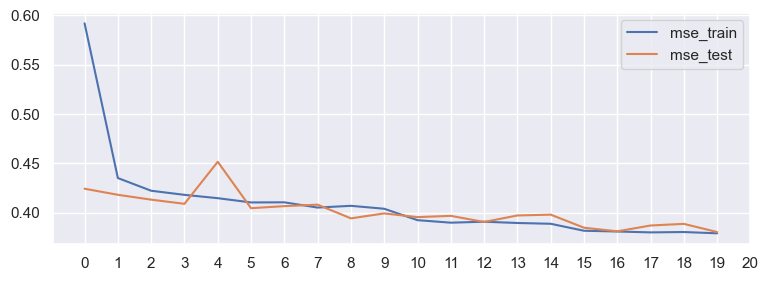

In [77]:
x = range(epochs)
fig = plt.figure(figsize=(9, 3))
sns.lineplot(x=x, y=hist[0], label="mse_train")
sns.lineplot(x=x, y=hist[1], label="mse_test")

plt.xticks(range(epochs+1))
plt.legend()
plt.show()

In [68]:
def predict(model, X):
    y_pred = []
    with torch.no_grad():
        for xb in X:
            xb = xb.to(device)
            output = model(xb)
            y_pred.append(output.item())
    return y_pred

In [70]:
df_ans = pd.read_csv("../data/dataset/sample_submission.csv")
df_ans["MedHouseVal"] = predict(model, test_loader)
df_ans.to_csv("ans_4.csv", index=False)